In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, verbose=0)

import warnings
warnings.filterwarnings("ignore")

# Problem with pydicom: https://stackoverflow.com/questions/60485393/jpeg2000-losses-read-dicom-in-python-3-7

In [2]:
PATH_INPUT = "/home/jupyter/DATA/"
PATH_TRAIN_IMAGES = PATH_INPUT+"train/"
PATH_TRAIN_IMAGES_RESIZED=PATH_INPUT+"resized/"
PATH_TRAIN_IMAGES_CSV_TRAIN=PATH_INPUT+"csv_train/"
PATH_TRAIN_IMAGES_CSV_TEST=PATH_INPUT+"csv_test/"
PATH_GCS_BUCKET = "gs://vinbigdatadaruai/"
PATH_GCS_IMAGES = PATH_GCS_BUCKET+"resized/"

def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
mkdir(PATH_TRAIN_IMAGES_RESIZED)
mkdir(PATH_TRAIN_IMAGES_CSV_TRAIN)
mkdir(PATH_TRAIN_IMAGES_CSV_TEST)

df_labels=pd.read_csv(PATH_INPUT+"train.csv")
df_labels["path"]=df_labels.image_id.apply(lambda x: PATH_TRAIN_IMAGES+f"{x}.dicom")
df_labels.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,/home/jupyter/DATA/train/50a418190bc3fb1ef1633...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,/home/jupyter/DATA/train/21a10246a5ec7af151081...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,/home/jupyter/DATA/train/9a5094b2563a1ef3ff50d...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,/home/jupyter/DATA/train/051132a778e61a86eb147...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,/home/jupyter/DATA/train/063319de25ce7edb9b1c6...


In [3]:
# Change class_id values
df_labels.class_id=df_labels.class_id+1
df_labels.loc[df_labels.class_id==15,"class_id"]=0

In [4]:
# Colormap
labels_info=df_labels.query("class_id!=0")[["class_id","class_name"]].drop_duplicates().sort_values(by="class_id").reset_index(drop=True)
labels_info["color"]=sns.color_palette("husl", labels_info.shape[0])
labels_info["color"]=labels_info["color"].apply(lambda x: tuple([int(cl*255) for cl in x]))
labels_info=labels_info.set_index("class_id",drop=True)
labels_info

,class_name,color
class_id,,
1,Aortic enlargement,"(246, 112, 136)"
2,Atelectasis,"(239, 124, 50)"
3,Calcification,"(197, 147, 49)"
4,Cardiomegaly,"(167, 158, 49)"
5,Consolidation,"(130, 168, 49)"
6,ILD,"(49, 178, 77)"
7,Infiltration,"(52, 175, 137)"
8,Lung Opacity,"(53, 172, 164)"
9,Nodule/Mass,"(55, 170, 186)"


In [5]:
## Reading a dicom file
# From: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import exposure
import cv2

def dicom2array(path, voi_lut=True, fix_monochrome=True, equalize_hist=False, clahe_normalization=False):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    # From: https://www.kaggle.com/raddar/popular-x-ray-image-normalization-techniques
    if equalize_hist:
        data = exposure.equalize_hist(data)
        
    if clahe_normalization:
        data = exposure.equalize_adapthist(data/np.max(data))
        
    data = (data * 255).astype(np.uint8)
        
    return data

def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()
    
def plot_img_with_labels(image_id,df_labels, labels_info, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    df_plot = df_labels.query(f"image_id=='{image_id}'")
    img=dicom2array(df_plot.iloc[0].path)
    
    # To rgb:
    img=cv2.merge((img, img, img))
    # Draw boxes if present
    df_boxes = df_plot.query("class_id!=0")
    if df_boxes.shape[0]>0:
        for i,row in df_boxes.iterrows(): #x_min	y_min	x_max	y_max
            img = cv2.rectangle(img,(int(row.x_min), int(row.y_min)),(int(row.x_max), int(row.y_max)), labels_info.loc[row.class_id]["color"],5)
            
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

In [6]:
# Train / test split
# As a first approach, lets use train and test split (using test also for validation)
# TODO: Use Train / Validation / Test or kFold
import random

imgs_to_process=df_labels.image_id.unique()


random.seed(10)
random.shuffle(imgs_to_process)

perc=0.8
train_ids, test_ids=imgs_to_process[:int(len(imgs_to_process)*perc)],imgs_to_process[int(len(imgs_to_process)*perc):]

df_labels["split"]="test"
df_labels.loc[df_labels.image_id.isin(train_ids),"split"]="train"

df_train, df_test = df_labels.query("split=='train'"),df_labels.query("split=='test'")

<AxesSubplot:xlabel='class_name'>

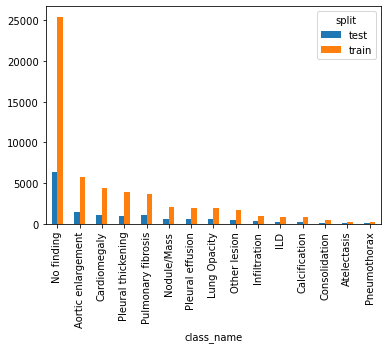

In [7]:
df_labels.groupby(["split"]).class_name.value_counts().unstack().T.sort_values(by="train",ascending=False).plot.bar()

In [8]:
df_train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,path,split
0,50a418190bc3fb1ef1633bf9678929b3,No finding,0,R11,NaN,NaN,NaN,NaN,/home/jupyter/DATA/train/50a418190bc3fb1ef1633...,train
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,0,R7,NaN,NaN,NaN,NaN,/home/jupyter/DATA/train/21a10246a5ec7af151081...,train
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,4,R10,691.0,1375.0,1653.0,1831.0,/home/jupyter/DATA/train/9a5094b2563a1ef3ff50d...,train
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,1,R10,1264.0,743.0,1611.0,1019.0,/home/jupyter/DATA/train/051132a778e61a86eb147...,train
4,063319de25ce7edb9b1c6b8881290140,No finding,0,R10,NaN,NaN,NaN,NaN,/home/jupyter/DATA/train/063319de25ce7edb9b1c6...,train


In [9]:
df_test.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,path,split
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,14,R9,1857.0,1607.0,2126.0,2036.0,/home/jupyter/DATA/train/afb6230703512afc370f2...,test
12,5550a493b1c4554da469a072fdfab974,No finding,0,R9,NaN,NaN,NaN,NaN,/home/jupyter/DATA/train/5550a493b1c4554da469a...,test
18,5da264775732004f1b724b660138854a,Aortic enlargement,1,R9,1635.0,673.0,1978.0,1151.0,/home/jupyter/DATA/train/5da264775732004f1b724...,test
40,8e063eadea9a6aeb684c893c8598be3e,Nodule/Mass,9,R10,376.0,1867.0,438.0,1914.0,/home/jupyter/DATA/train/8e063eadea9a6aeb684c8...,test
46,d86c7405606f965ab7300ef1eacbcacc,No finding,0,R4,NaN,NaN,NaN,NaN,/home/jupyter/DATA/train/d86c7405606f965ab7300...,test


In [10]:
# Functions to format the data for the MaskRCNN model: https://www.kaggle.com/frlemarchand/maskrcnn-for-chest-x-ray-anomaly-detection

def get_mask(img_dimensions, x_min, y_min, x_max, y_max):
    """ Return mask format for RCNN
    Given a x_min, y_min, x_max, y_max segmentation (object detection type) returns a mask
    """
    img_height, img_width = img_dimensions
    img_mask = np.full((img_height,img_width),0) # Initialize the an image with same size as original image with zeros
    img_mask[y_min:y_max,x_min:x_max] = 255 # Fill the object area with 255 values
    
    return img_mask.astype(np.float32)


def rle_encoding(x):
    dots = np.where(x.T.flatten() == 255)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])


def get_image_labels(df,dicom_folder, resized_folder, image_size=512):
    diagnostic_per_image = []

    for image_id in tqdm(df.image_id.unique()):
        #image_id = row.image_id
        image_df = df.query(f"image_id=='{image_id}'").query("class_id!=0") # Select all rows for an image id
        class_list = []
        RLE_list = []
        
        # Load image
        dicom_image = dicom2array(dicom_folder+image_id+".dicom",clahe_normalization=True)
        image_dimensions = dicom_image.shape
        
        # Resize and save image
        resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)
        cv2.imwrite(resized_folder+image_id+".jpg", resized_img) 
        
        if image_df.shape[0]==0: # No annotations in the image
            class_list.append(0)
            mask = np.full(image_dimensions,0).astype(np.float32)
            resized_mask = cv2.resize(mask, (image_size,image_size))
            RLE_list.append(rle_encoding(resized_mask))
            
        else:
            for diagnostic_id, diagnostic in image_df.iterrows(): # For each annotation...
                class_list.append(diagnostic.class_id)

                mask = get_mask(image_dimensions, int(diagnostic.x_min), int(diagnostic.y_min), int(diagnostic.x_max), int(diagnostic.y_max))
                resized_mask = cv2.resize(mask, (image_size,image_size))
                RLE_list.append(rle_encoding(resized_mask))
                
        diagnostic_per_image.append({"image_id":image_id,
                                     "CategoryId":class_list,
                                     "EncodedPixels":RLE_list})
        
    samples_df = pd.DataFrame(diagnostic_per_image)
    samples_df["Height"] = image_size
    samples_df["Width"] = image_size
    return samples_df

In [11]:
def get_image_labels_per_sample(image_id,dicom_folder,resized_folder,path_csv,image_size=512):
    diagnostic_per_image=[]
    image_df = df_train.query(f"image_id=='{image_id}'").query("class_id!=0") # Select all rows for an image id
    class_list = []
    RLE_list = []

    # Load image
    dicom_image = dicom2array(dicom_folder+image_id+".dicom",clahe_normalization=True)
    image_dimensions = dicom_image.shape

    # Resize and save image
    resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)
    cv2.imwrite(resized_folder+image_id+".jpg", resized_img) 

    if image_df.shape[0]==0: # No annotations in the image
        class_list.append(0)
        mask = np.full(image_dimensions,0).astype(np.float32)
        resized_mask = cv2.resize(mask, (image_size,image_size))
        RLE_list.append(rle_encoding(resized_mask))

    else:
        for diagnostic_id, diagnostic in image_df.iterrows(): # For each annotation...
            class_list.append(diagnostic.class_id)

            mask = get_mask(image_dimensions, int(diagnostic.x_min), int(diagnostic.y_min), int(diagnostic.x_max), int(diagnostic.y_max))
            resized_mask = cv2.resize(mask, (image_size,image_size))
            RLE_list.append(rle_encoding(resized_mask))

    diagnostic_per_image.append({"image_id":image_id,
                                 "CategoryId":class_list,
                                 "EncodedPixels":RLE_list})

    samples_df = pd.DataFrame(diagnostic_per_image)
    samples_df["Height"] = image_size
    samples_df["Width"] = image_size
    samples_df.to_csv(path_csv+f"{image_id}.csv",index=False)

In [12]:
df_train_ids=df_train.image_id.drop_duplicates()
def get_image_labels_per_sample_aux(image_id):
    get_image_labels_per_sample(image_id,dicom_folder=PATH_TRAIN_IMAGES,
                            resized_folder=PATH_TRAIN_IMAGES_RESIZED,
                            path_csv=PATH_TRAIN_IMAGES_CSV_TRAIN)
    
df_train_ids.parallel_apply(get_image_labels_per_sample_aux)

0        None
1        None
2        None
3        None
4        None
         ... 
62645    None
62892    None
63783    None
64200    None
64254    None
Name: image_id, Length: 12000, dtype: object

In [13]:
df_test_ids=df_test.image_id.drop_duplicates()

def get_image_labels_per_sample_aux(image_id):
    get_image_labels_per_sample(image_id,dicom_folder=PATH_TRAIN_IMAGES,
                            resized_folder=PATH_TRAIN_IMAGES_RESIZED,
                            path_csv=PATH_TRAIN_IMAGES_CSV_TEST)

df_test_ids.parallel_apply(get_image_labels_per_sample_aux)

9        None
12       None
18       None
40       None
46       None
         ... 
59288    None
60412    None
60511    None
60530    None
62963    None
Name: image_id, Length: 3000, dtype: object

In [6]:
import glob
all_files = glob.glob(PATH_TRAIN_IMAGES_CSV_TRAIN + "/*.csv")

fout=open("df_train_info.csv","a")
# first file:
for line in open(all_files[0]):
    fout.write(line)
# now the rest:    
for fil in all_files[1:]:
    f = open(fil)
    f.__next__() # skip the header
    for line in f:
         fout.write(line)
    f.close() # not really needed
fout.close()

pd.read_csv("df_train_info.csv").to_csv(PATH_GCS_BUCKET+"df_train_info.csv",index=False)

In [9]:
all_files = glob.glob(PATH_TRAIN_IMAGES_CSV_TEST + "/*.csv")

fout=open("df_test_info.csv","a")
# first file:
for line in open(all_files[0]):
    fout.write(line)
# now the rest:    
for fil in all_files[1:]:
    f = open(fil)
    f.__next__() # skip the header
    for line in f:
         fout.write(line)
    f.close() # not really needed
fout.close()

pd.read_csv("df_test_info.csv").to_csv(PATH_GCS_BUCKET+"df_test_info.csv",index=False)

In [ ]:
#df_train_info = get_image_labels(df_train, 
#                                 dicom_folder=PATH_TRAIN_IMAGES,
#                                 resized_folder=PATH_TRAIN_IMAGES_RESIZED)
#df_train_info.to_csv(PATH_GCS_BUCKET+"df_train_info.csv",index=False)

In [ ]:
#df_test_info = get_image_labels(df_test, 
#                                 dicom_folder=PATH_TRAIN_IMAGES,
#                                 resized_folder=PATH_TRAIN_IMAGES_RESIZED)
#df_test_info.to_csv(PATH_GCS_BUCKET+"df_test_info.csv",index=False)

In [ ]:
# Move images to GCS
!gsutil -m cp -r $PATH_TRAIN_IMAGES_RESIZED $PATH_GCS_BUCKET

In [ ]:
# Shutdown instance
!sudo poweroff